# Partie culstering : Analyse de la relation entre les vitesses horizontales et verticales de l'avion et la position du levier 
On analysera dans cette partie un vol du premier avion

In [1]:
%reload_ext autoreload
%autoreload 2

# module
import sys
sys.path.append("../")
from src import * 

# chemin vers la donnee 
data_dir = 'C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive/'
#data_dir = 'C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive/'
filelist = glob.glob(data_dir + '*.h5')
filelist

['C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_01.h5',
 'C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_01_dask.h5',
 'C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_02.h5',
 'C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_02_dask.h5',
 'C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_03.h5',
 'C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_03_dask.h5']

In [77]:
ddf = lire_hdf_dask(filelist[0], repertoire= data_dir)
df = ddf.partitions[0].compute()

In [78]:
def add_speed(df) :
    ON_AIR = df['M [Mach]']>0
    dy= np.empty(len(df))
    y = df['ALT [ft]'].values
    dy[:-1] = y[1:]-y[:-1]
    dy[-1]=0
    df['dy [m/s]'] =dy *0.3
    df['dx [m/s]'] = df['M [Mach]']*343
    df['ON_AIR'] = ON_AIR
    return df


df_speed = add_speed(df)

On crée plusieur dataframe sur lesquels nous allons faire nos analyses 

C:\Users\felix\AppData\Local\Temp\ipykernel_13256\2838138250.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reg2['levier']=data_levier
C:\Users\felix\AppData\Local\Temp\ipykernel_13256\2838138250.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reg2['theta']=theta
C:\Users\felix\AppData\Local\Temp\ipykernel_13256\2838138250.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

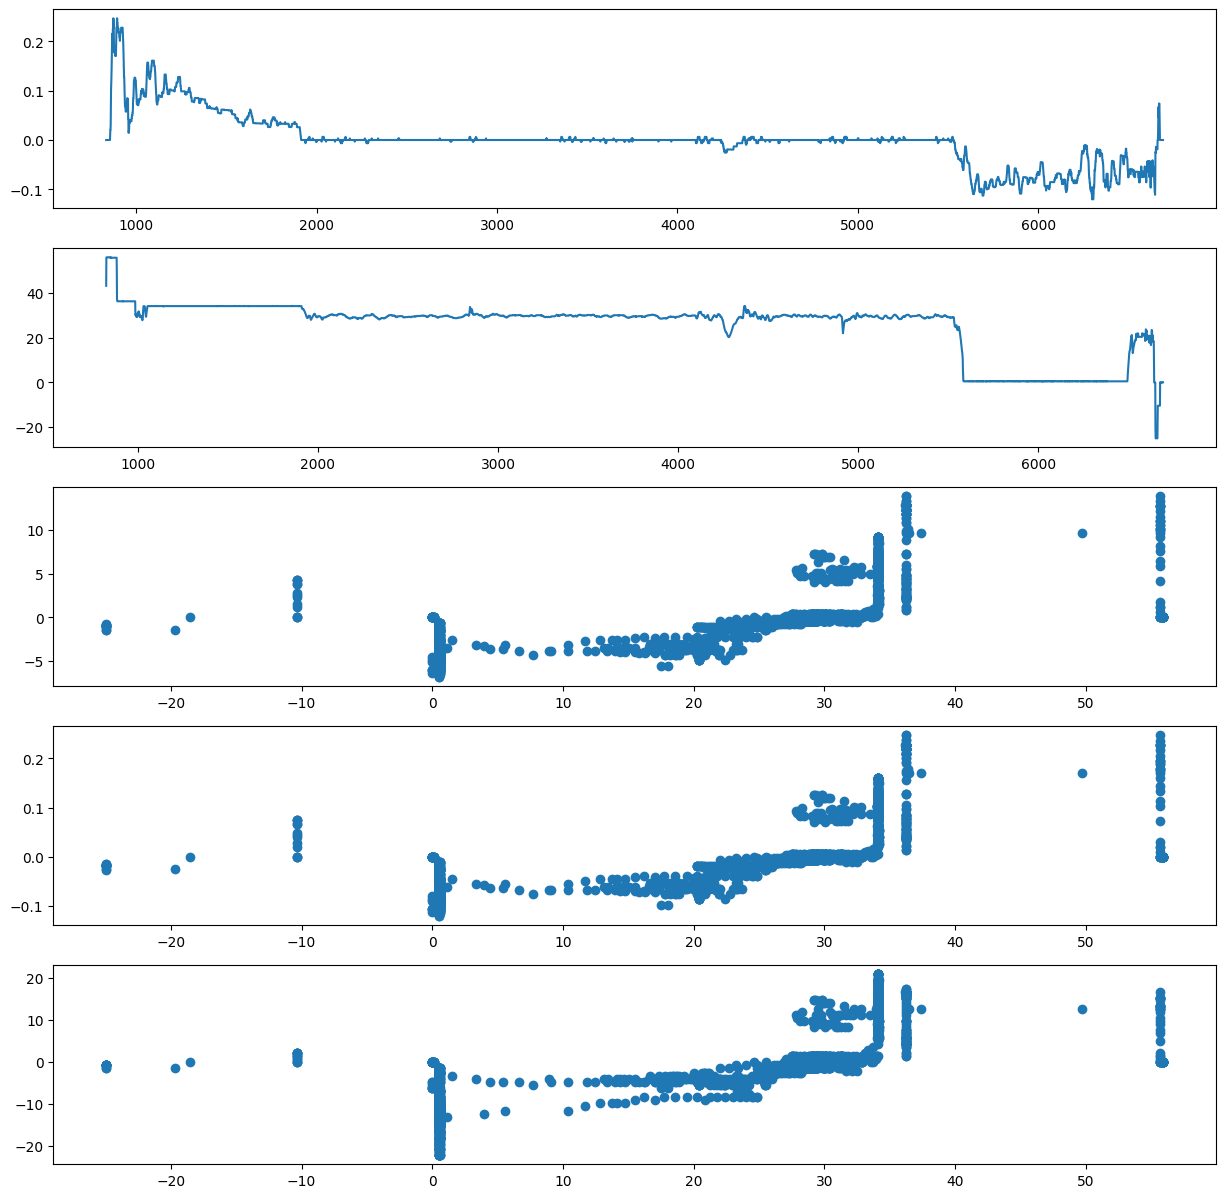

In [79]:
id_on_air = df_speed['dx [m/s]']>0 
vx = df_speed['dx [m/s]'][id_on_air].values
vy = df_speed['dy [m/s]'][id_on_air].rolling(window =10).median().values
quot = vy/vx
theta = np.arctan(quot)*180/np.pi
data_levier = df_speed[id_on_air]['TLA_1 [deg]'].values
tps = df_speed[id_on_air].index.values

df_reg = pd.DataFrame({'levier': data_levier, 'theta' : theta, 'vx': vx, 'vy':vy, 'quot': quot, 'time' :tps }).set_index('time')
#creation d'un data frame analyse felix 
df_reg2=df_speed[id_on_air]
df_reg2['levier']=data_levier
df_reg2['theta']=theta
df_reg2['vx']=vx
df_reg2['vy']=vy
df_reg2['quot']=quot
df_reg2['time']=tps


fig, axs = plt.subplots(5, figsize = (15,15))
axs[0].plot(df_speed.index[id_on_air].values, quot)
axs[1].plot(df_speed[id_on_air].index.values, df_speed[id_on_air]['TLA_1 [deg]'].values)
axs[2].scatter(data_levier, theta)
axs[3].scatter(data_levier, quot)
axs[4].scatter(data_levier, vy)



# Clustering en utilisant la méthode Kmeans sur les données de Valentin et sur une ACP

In [80]:
from sklearn.cluster import KMeans

In [81]:
from sklearn.decomposition import PCA

In [82]:
from sklearn.preprocessing import StandardScaler

On met les données dont on veut faire le clustering dans le format adéquat deplus on suprime les 10 première valeur qui correspondent à des NaN

In [83]:
QUOT=quot[10:]
DATA_LEV=data_levier[10:]
#ATTENTION COMME ON FAIT UNE MOYENNE GLISSANT IL FAUDRAIT PEUT ETRE ENLEVER LES 100 PREMI7RE VALEUR DE DATALEVIER
sum(np.isnan(QUOT)==True)
ARCT=np.arctan(QUOT)

In [84]:
#creation du tableau pour l'étude dit naive
Array2D=np.column_stack((QUOT,DATA_LEV))
Array2D2=np.column_stack((ARCT,DATA_LEV))
len(ARCT)

5859

Pour la suite de ce analyse on va utiliser des algorythmes utilisant que des données numérique donc on drop toute les variables non numériques. Deplus comme les données peuvent être trés différente des unes des autres on normalise les données.

In [85]:
DF_kluster=df_reg2.drop(['ON_AIR','PRV_2 [bool]','PRV_1 [bool]','NAIV_1 [bool]','NAIV_2 [bool]'],axis=1).iloc[10:]

Comme vu dans le TD de Madane on normalise le dataframe, on calucule les directions principale et enfain on projère les données le long de ces direnctions (Ici 2 direction par souci de visualisation)

In [86]:

X_vol_norm = StandardScaler().fit_transform(DF_kluster)
vol_pca = PCA(n_components=2).fit(X_vol_norm)
vol_proj = vol_pca.transform(X_vol_norm)

Part de variance expliquée par CP :
[0.55036355 0.27725413]
Pourcentage de variance totale expliquée :
82.76176827762434 %


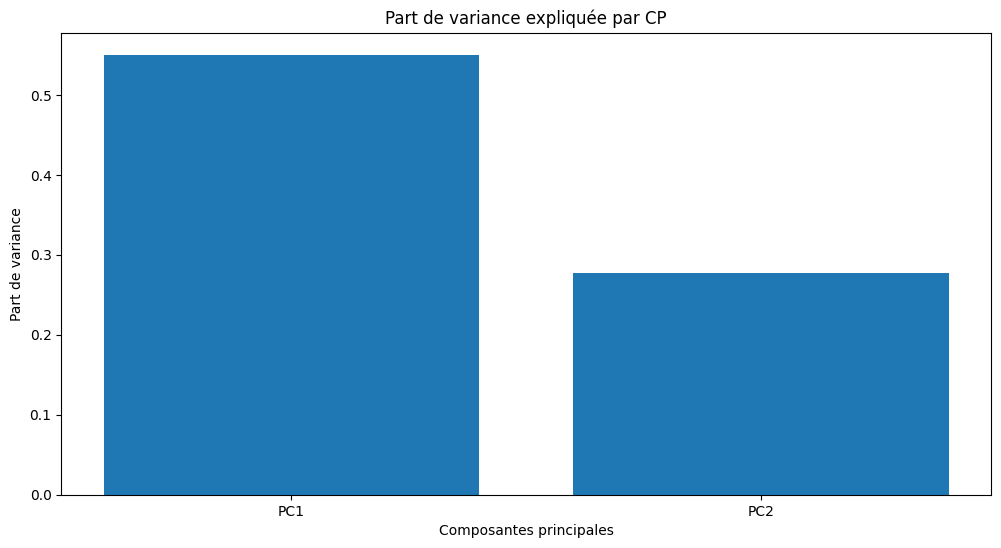

In [87]:
print('Part de variance expliquée par CP :')
print(vol_pca.explained_variance_ratio_)
print('Pourcentage de variance totale expliquée :')
print(vol_pca.explained_variance_ratio_.sum()*100, '%')

plt.figure(figsize=(12,6))
plt.bar(np.arange(vol_pca.n_components), vol_pca.explained_variance_ratio_, tick_label=['PC'+str(i+1) for i in range(vol_pca.n_components)], log=False)
plt.title('Part de variance expliquée par CP');
plt.ylabel('Part de variance')
plt.xlabel('Composantes principales');

Après avoir vu que les données avait deux directions privilégiés qui expliquait 80% de la variance, on regarde la projection de celles-ci sur ces deux direction avec une color bar qui dépends du temps écoulé. On remarque quelle que chose de puissant c'est que pendant le vol la projection des données suivant les directions pricipales varie mais de façon "CONTINUE" autrement dit les projections des données sont proche des unes des autre si elles sont proche dans le temps.

Text(0.5, 1.0, 'Projection PCA du vol')

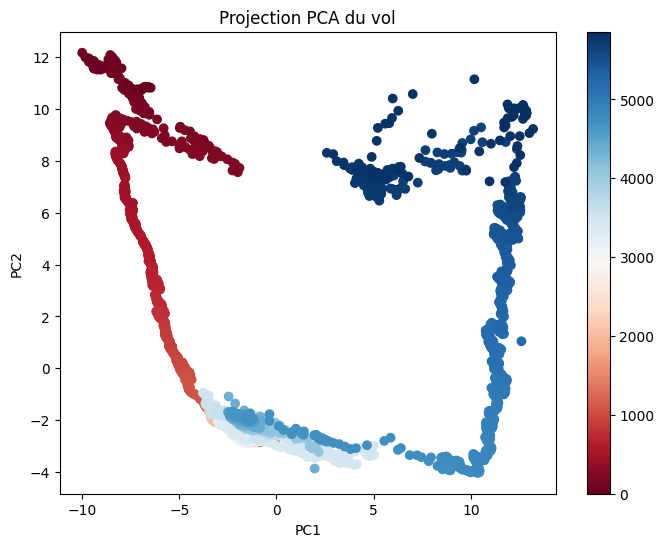

In [88]:
plt.figure(figsize=(8,6))
plt.scatter(vol_proj[:, 0], vol_proj[:, 1], cmap='RdBu', c=np.arange(vol_proj.shape[0]))
plt.colorbar()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Projection PCA du vol')

Le décolage de l'avion correspond à la partie en rouge foncé et l'attérissage en bleu foncé, on remarque trés bien la symétrie des données du surement à la symétrie du vol (une phase de monté croisière puis descante )
Remarque: Evidament si on ajoute de nouvelles variables on change l'ACP et les directions pricipales mais le caractère "continue" persiste (CF :Felix002)

On fait un clutering pour bien confirmer que une proximité en temps représente aussi une proximité dans les autre valeur physique (ce qui a du sens physiquement)

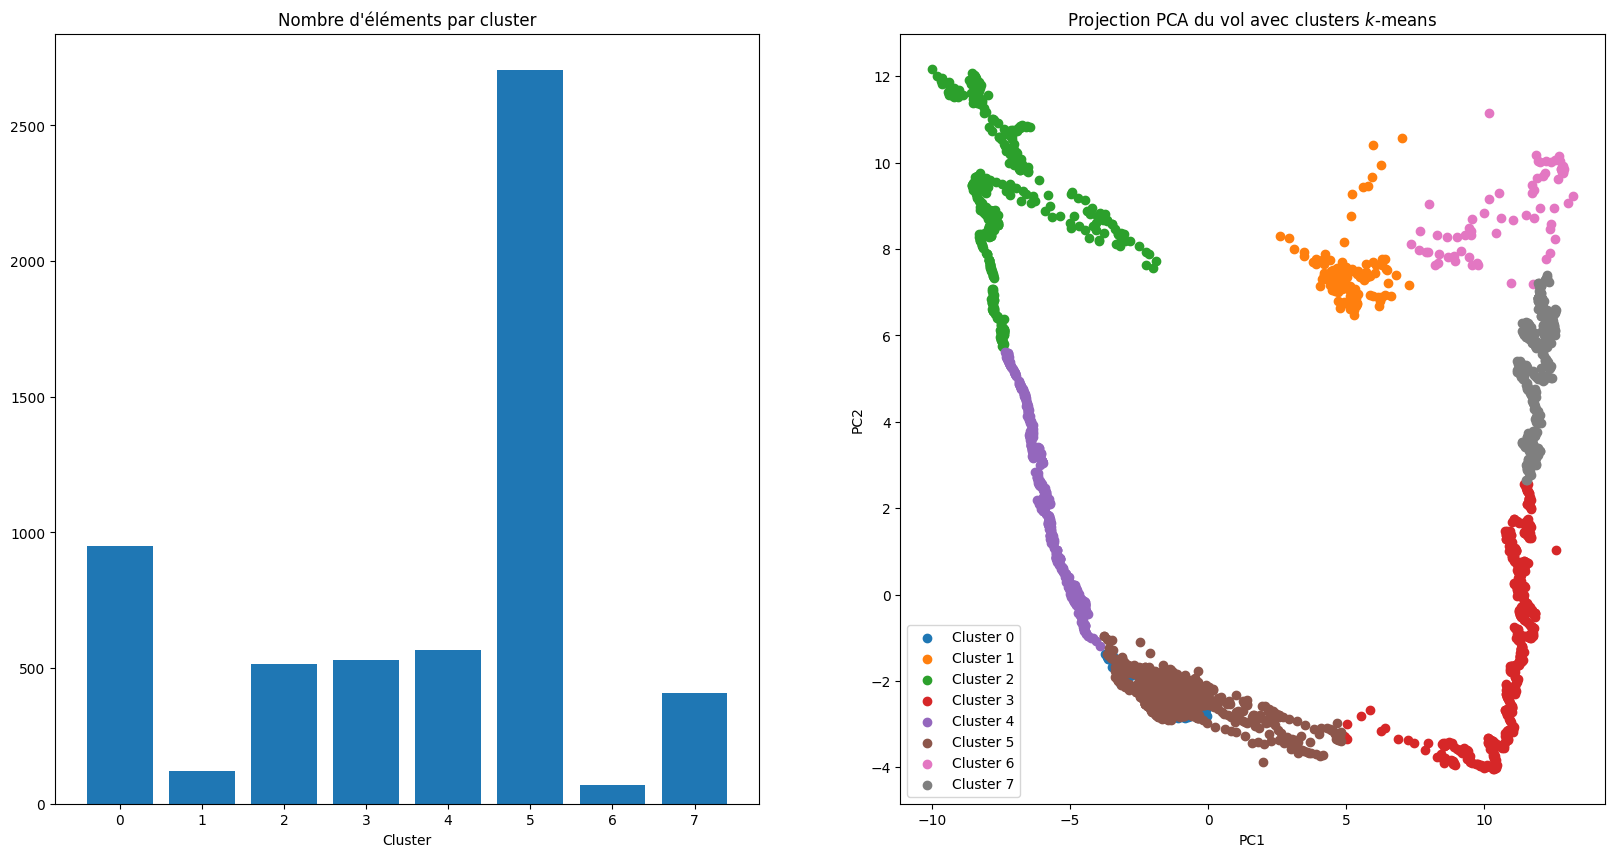

In [112]:
K = 8

km = KMeans(n_clusters=K, n_init=10)
labels = km.fit_predict(X_vol_norm)
cnt = np.bincount(labels)

fig,ax = plt.subplots(1, 2, figsize=(20,10))

ax[0].bar(np.arange(K), cnt, tick_label=np.arange(K))
ax[0].set_title('Nombre d\'éléments par cluster')
ax[0].set_xlabel('Cluster')

for c in range(km.n_clusters):
    ax[1].scatter(vol_proj[labels == c, 0], vol_proj[labels == c, 1], label="Cluster "+str(c))
ax[1].legend()
ax[1].set_xlabel('PC1')
ax[1].set_ylabel('PC2')
ax[1].set_title('Projection PCA du vol avec clusters $k$-means');

On remarque que la classe 0 est celle ou il y le plus de données cela était prévisible puiqu'il s'agit de la croisière qui représente la majorité du trajet.

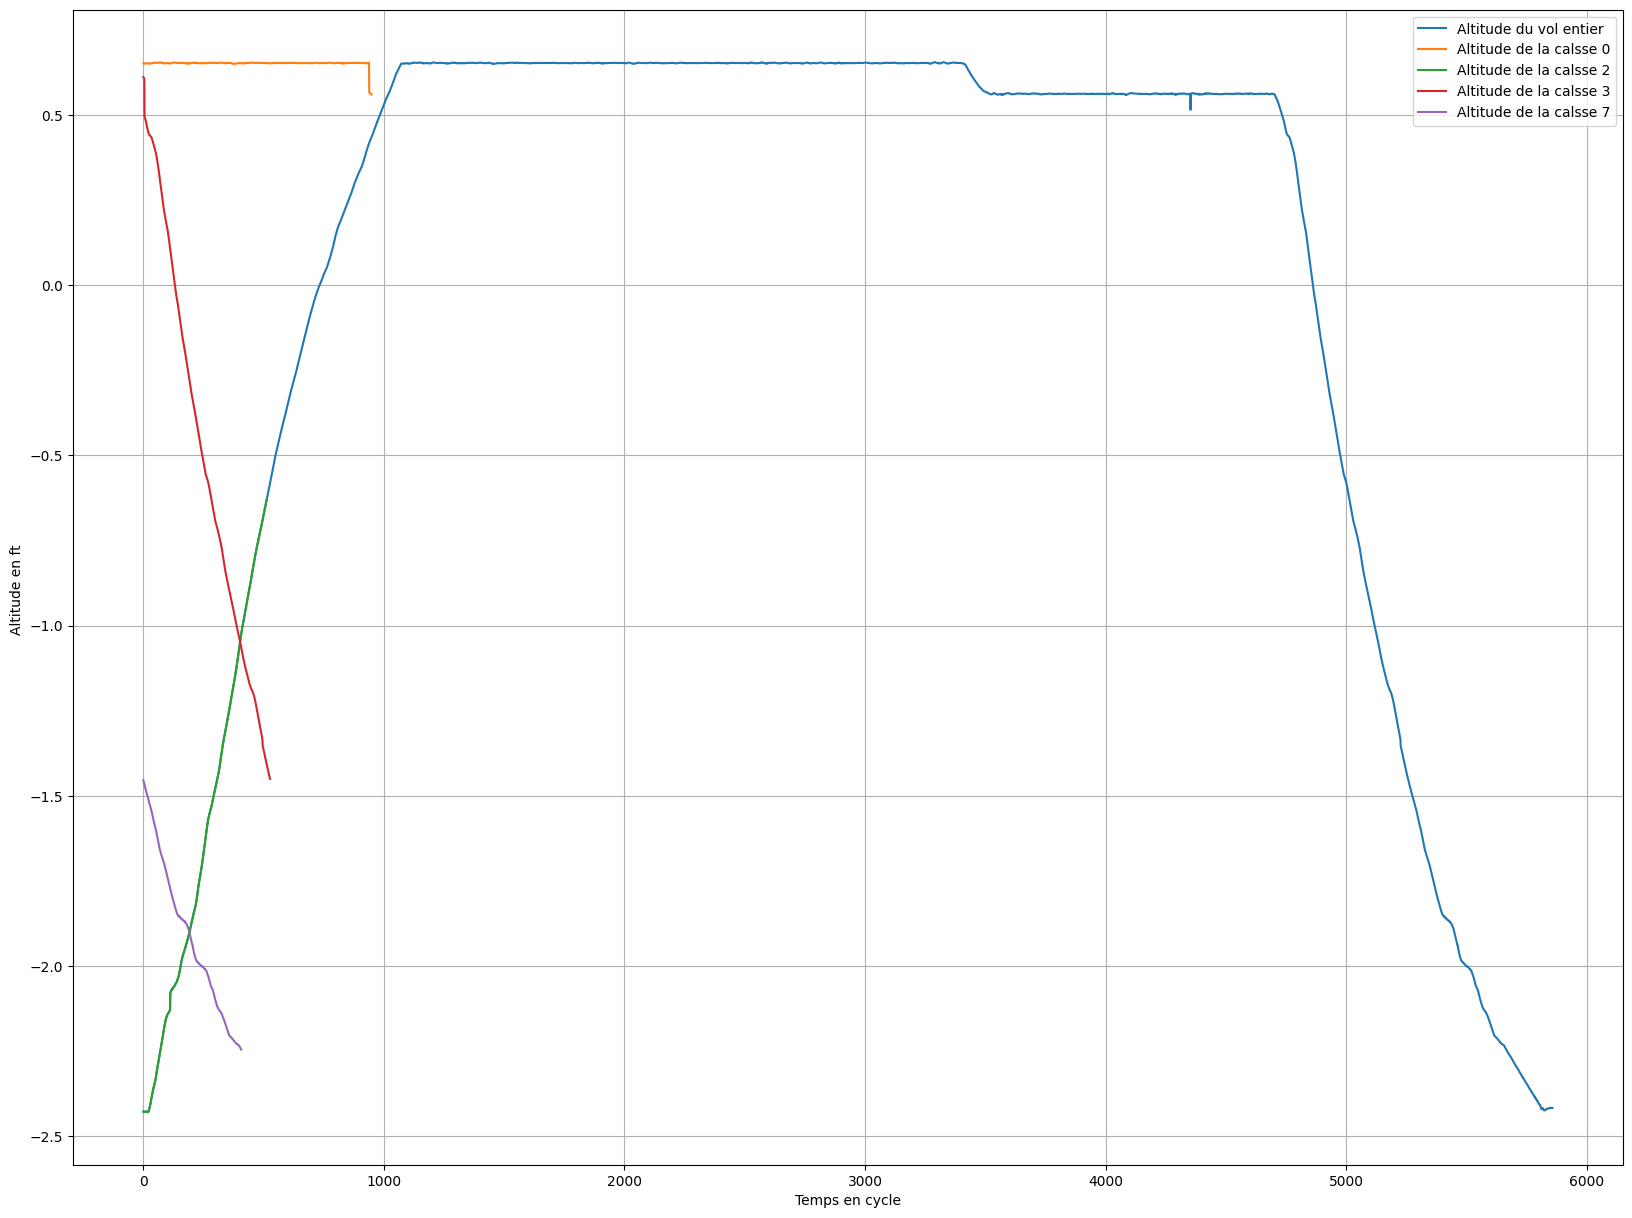

In [128]:
#ATTENTION données normalizé
fig, ax = plt.subplots(figsize=(20,15))
ax.plot(X_vol_norm[labels==5,0], label = 'Altitude de la calsse 5' )
ax.plot(X_vol_norm[:,0],label = 'Altitude du vol entier')
ax.plot(X_vol_norm[labels==0,0], label = 'Altitude de la calsse 0' )
ax.plot(X_vol_norm[labels==2,0], label = 'Altitude de la calsse 2' )
ax.plot(X_vol_norm[labels==3,0], label = 'Altitude de la calsse 3' )
ax.plot(X_vol_norm[labels==7,0], label = 'Altitude de la calsse 7' )
ax.set_ylabel('Altitude en ft ')
ax.set_xlabel('Temps en cycle')
ax.legend()
ax.grid()



On reconnait bien des portions de la courbe du vol entier ( a un déplacemet d'indice pret ) Ce graphe nous confirme bien que le clutering représente bien les différente phase de vol et que le classe 5 représente la croisière.

## Mauvaise utilisation de K-means
Je donne à l'algorythme de Kmeans seulement les données de l'angle du levier et de celui de l'avion (angle d'attaque)


Text(0.5, 0, 'quot')

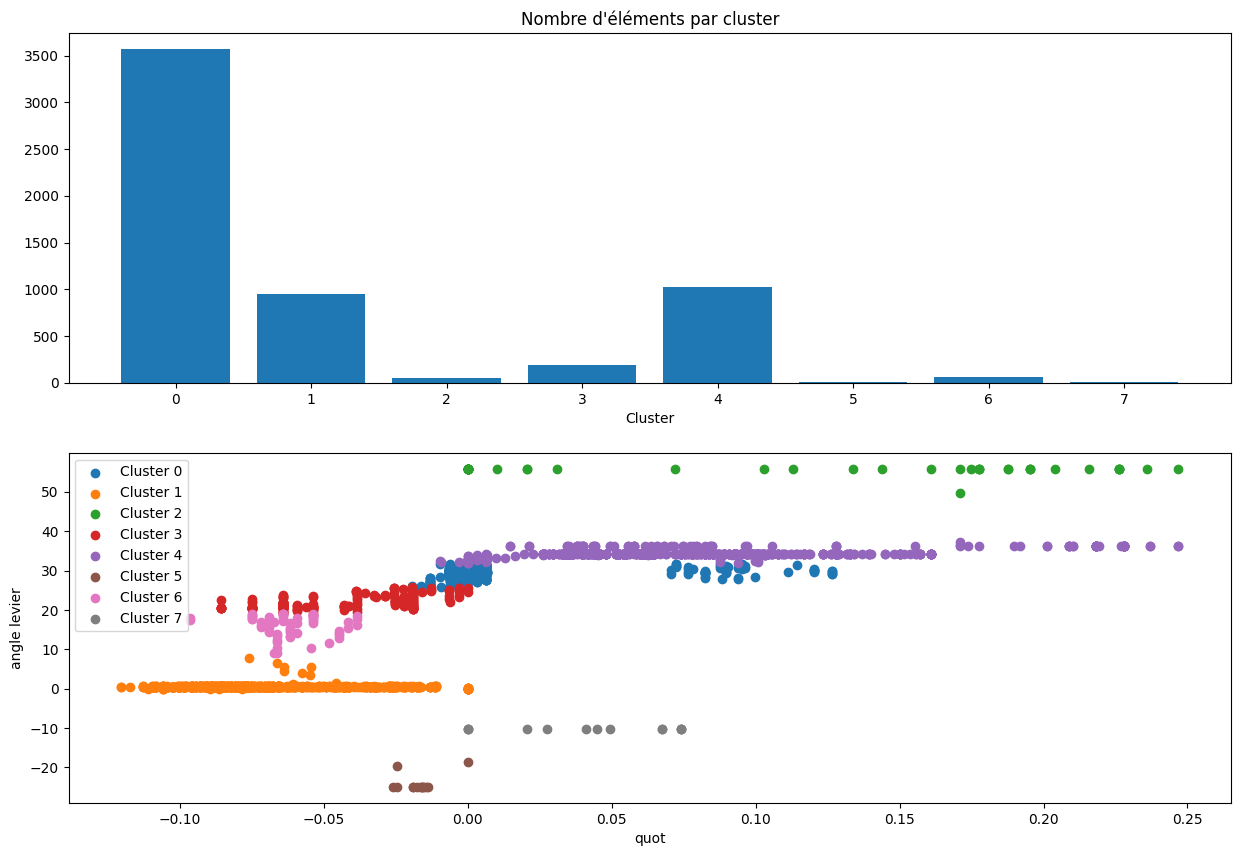

In [164]:
#creation d'un tableau 2D
#definit notre nombre de centroïde
K = 8

km = KMeans(n_clusters=K, n_init=10)
labels = km.fit_predict(Array2D)

cnt = np.bincount(labels)

fig,ax = plt.subplots( 2, figsize=(15,10))

ax[0].bar(np.arange(K), cnt, tick_label=np.arange(K))
ax[0].set_title('Nombre d\'éléments par cluster')
ax[0].set_xlabel('Cluster')
for c in range(km.n_clusters):

    ax[1].scatter(Array2D[labels == c, 0], Array2D[labels == c, 1], label="Cluster "+str(c))
ax[1].legend()
ax[1].set_ylabel('angle levier')
ax[1].set_xlabel('quot') # onpeut remplacer par ARCT c'est sensiblement la même chose


Il me sépare temps bien que mal les données et on remarque qu'il sépare de manière horizontale ce qui pourrait s'expliquer par un odres de grandeur d'un facteur 100 entre l'ordonnée et l'abcisse. La lecture du graphique nous indique que  le levier a des valeurs préferencielles

Pour faire un clutering pertinent j'ai décidé de faire un clutering sur l'enssemble du dataframe ainsi l'algorithme du K-means trouve les centroïles plus pertinent(qui minimise la distance au sain de sa classe)
Et ensuite je représente suivant la labeliation trouvé le graphe de l'angle du levier en fonction de celui de l'avion.

Text(0.5, 0, 'theta')

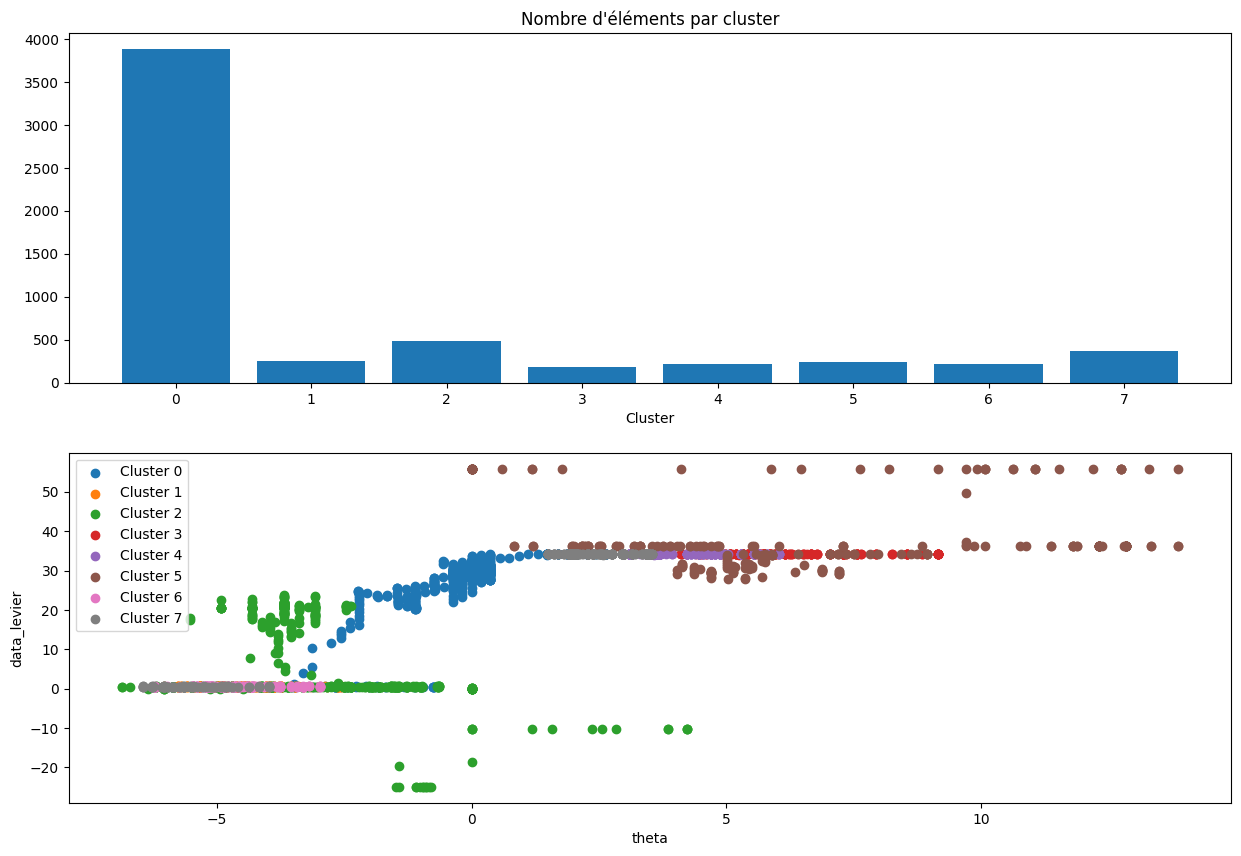

In [140]:
#creation d'un tableau 2D
#definit notre nombre de centroïde
K = 8
ID=[]
km2 = KMeans(n_clusters=K, n_init=10)
labels = km2.fit_predict(DF_kluster)
ID_kluster=labels
cnt = np.bincount(labels)

fig,ax = plt.subplots( 2, figsize=(15,10))

ax[0].bar(np.arange(K), cnt, tick_label=np.arange(K))
ax[0].set_title('Nombre d\'éléments par cluster')
ax[0].set_xlabel('Cluster')
for c in range(km2.n_clusters):
    ID_kluster=(labels==c)
    ID.append(ID_kluster)
    ax[1].scatter(DF_kluster['theta'][ID_kluster], DF_kluster['levier'][ID_kluster], label="Cluster "+str(c))
ax[1].legend()
ax[1].set_ylabel('data_levier')
ax[1].set_xlabel('theta')


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   quot   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     6552.
Date:                Sun, 03 Dec 2023   Prob (F-statistic):               0.00
Time:                        12:26:19   Log-Likelihood:                 11380.
No. Observations:                5859   AIC:                        -2.276e+04
Df Residuals:                    5857   BIC:                        -2.274e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0778      0.001    -72.950      0.000      -0.080      -0.076
levier         0.0031   3.81e-05     80.942      0.000       0.003       0.003
==============================================================================
Omnibus:                     3108.824   Durbin-Watson:                   0.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            22723.861
Skew:                           2.478   Prob(JB):                         0.00
Kurtosis:                      11.277   Cond. No.                         65.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

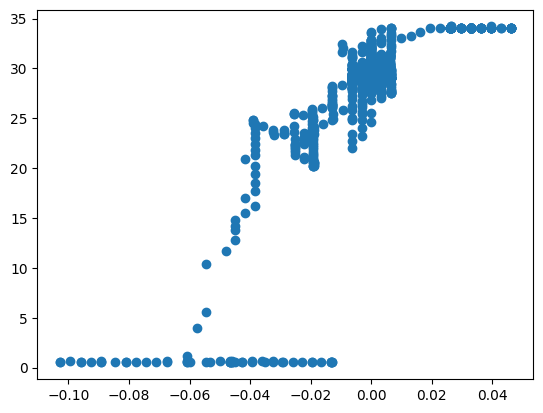

In [163]:
cluster=0
X=DF_kluster['levier'][ID[cluster]]
Y=DF_kluster['quot'][ID[cluster]]
plt.scatter(Y,X)
#reg=pd.DataFrame({'levier':X,'quotient':Y})
model=ols(formula="quot~levier",data=DF_kluster).fit()
model.summary()

On remarque qu'il y certaine dépendance entre l'angle d'attaque et celui du levier mais une simple regression nous donne un R^2 assez moyen, un façon d'améliorer la regression linéaire et d'augmenter le nombre de paramètre lié au contexte dans la formule. (expemple quot~levier+time) ou quot~levier+ N1 par exemple

# On fait une étude de la corélation par cluster 


In [94]:
import seaborn as sns


In [172]:
cluster=6 #on peut faire varié le cluster pour voir les corelation 

In [173]:
DF_kluster[ID[cluster]]
corr = DF_kluster[ID[cluster]].corr()
corr2 = DF_kluster.corr()

<Axes: >

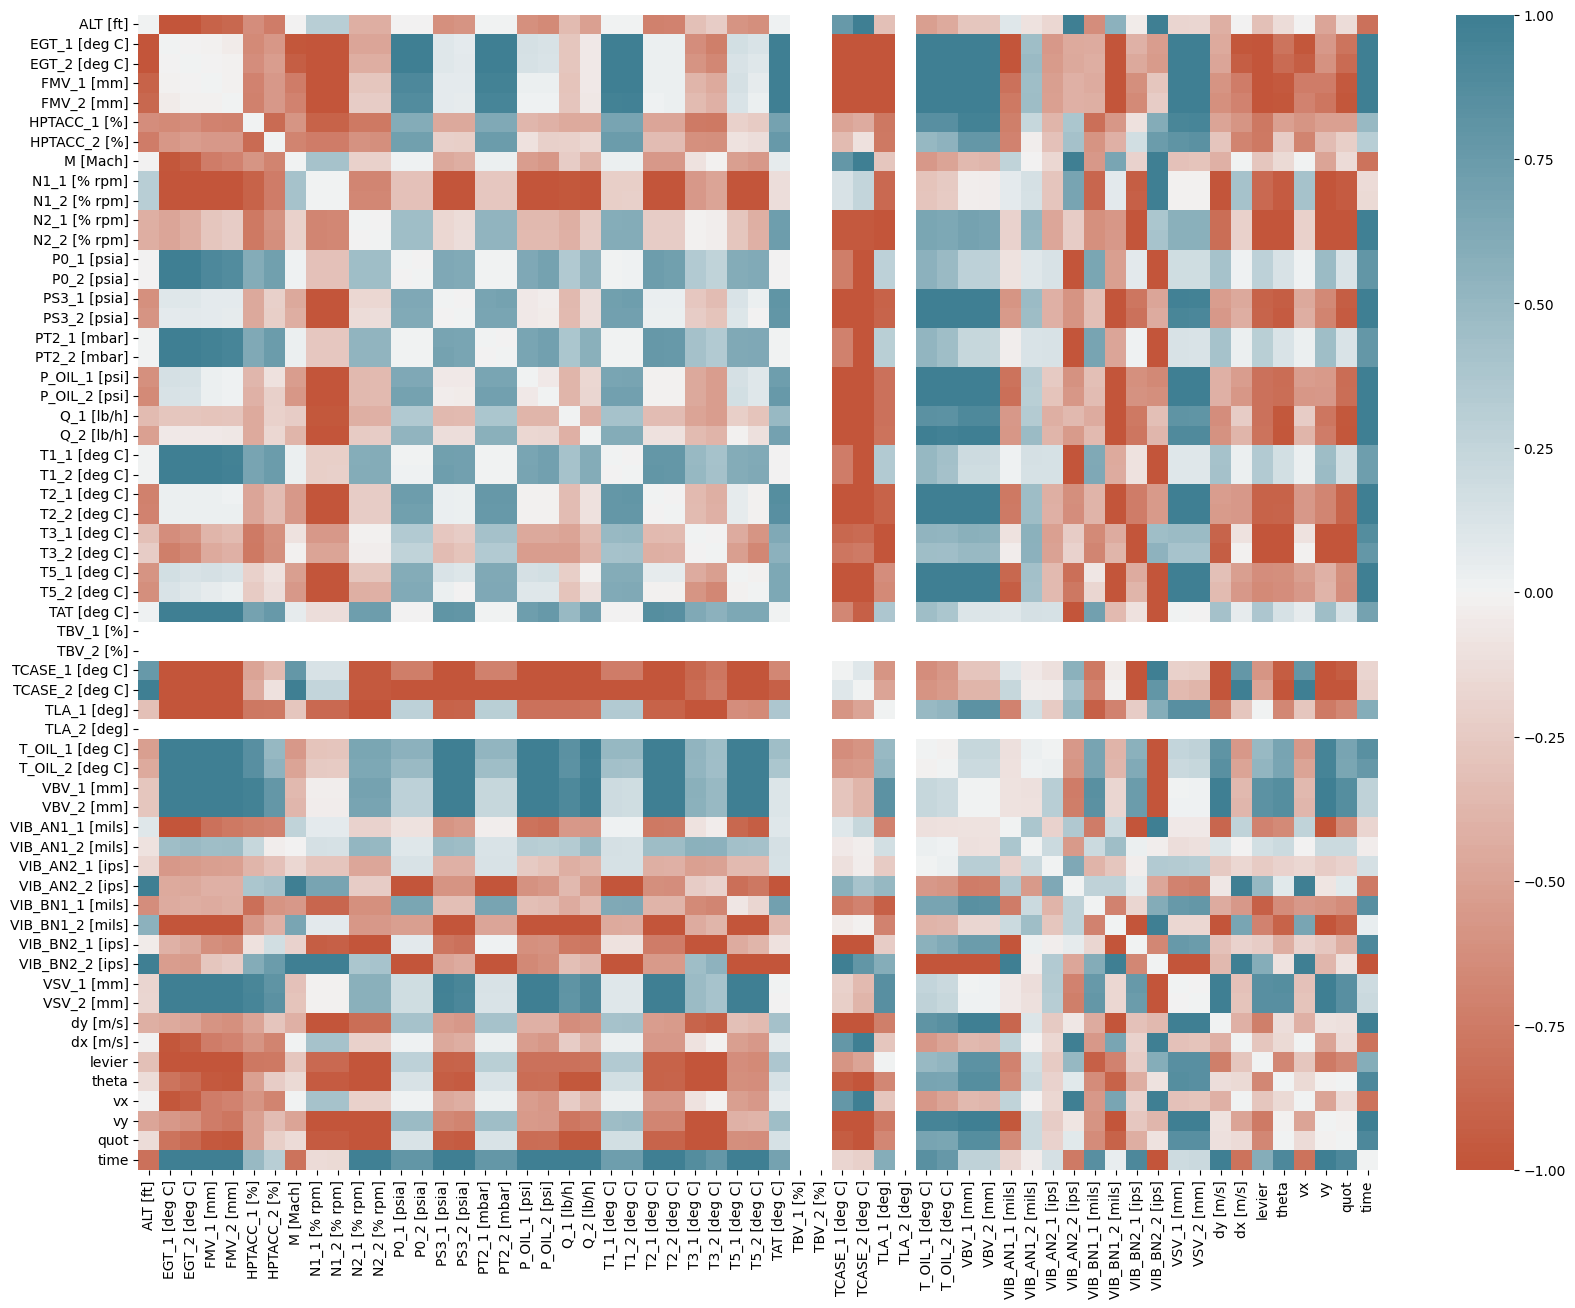

In [174]:
fig = plt.figure(figsize=(20,15))

sns.heatmap(corr-corr2, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, annot=False, fmt='.2f', vmin=-1, vmax=1, center=0, 
        cmap=sns.diverging_palette(20, 220, n=200))


In [137]:
Corelation_levier_quot=[]
for i in range(0,6):
    df_cor2=DF_kluster[ID[i]]
    corr2 = df_cor2.corr()
    
    Corelation_levier_quot.append(corr2['levier']['quot'])

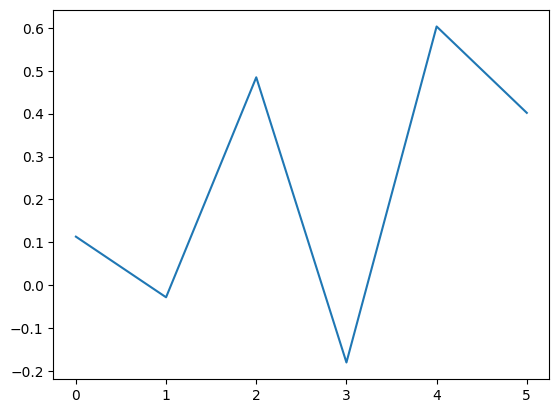

In [138]:
plt.plot(Corelation_levier_quot)